In [ ]:
!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

In [ ]:
import medmnist
print(medmnist.__version__)
from medmnist import INFO

In [ ]:
# Library imports:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from medmnist import OCTMNIST
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Normalizing the pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load and preprocess the datasets
train_dataset = OCTMNIST(split="train", download=True, transform=transform)
test_dataset = OCTMNIST(split="test", download=True, transform=transform)
val_dataset = OCTMNIST(split="val", download=True, transform=transform)

# CNN Model
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaseCNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print(train_dataset)

In [ ]:
# Hyperparameters
batch_size = 64
num_epochs = 3
learning_rate = 0.01

In [ ]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# checking the labels column to see if squeeze is required
images, labels = next(iter(train_loader))
print(labels.shape)
print(labels)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct = 0
    total_images = 0

    for images, labels in train_loader:
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    train_accuracy = total_correct / total_images
    avg_train_loss = total_train_loss / len(train_loader)


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.4f}')

    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_images = 0
    with torch.no_grad():
      for images, labels in val_loader:
          labels = labels.squeeze()

          outputs = model(images)
          loss = loss_function(outputs, labels)
          total_val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_correct += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_correct / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.4f}')

Epoch [1/3], Loss: 0.6466, Accuracy: 76.5637
Validation Loss: 0.4898, Accuracy: 82.8194
Epoch [2/3], Loss: 0.4622, Accuracy: 83.5992
Validation Loss: 0.4251, Accuracy: 84.6566


In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
total_correct = 0
total_images = 0
actuals = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        actuals.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())


# Test accuracy
test_accuracy = total_correct / total_images
print(f'Test Accuracy: {test_accuracy*100:.4f}')


# Confusion matrix
cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


L2 Regularisation

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct = 0
    total_images = 0

    for images, labels in train_loader:
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct / total_images

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.4f}')

    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_images = 0
    with torch.no_grad():
      for images, labels in val_loader:
          labels = labels.squeeze()

          outputs = model(images)
          loss = loss_function(outputs, labels)
          total_val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_correct += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_correct / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.4f}')



In [ ]:
model.eval()

actuals = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        actuals.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

actuals = np.array(actuals)
predictions = np.array(predictions)

accuracy = (actuals == predictions).mean()

print(f'testing Accuracy: {accuracy*100:.4f}')

# Confusion matrix
cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


Dropout

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNwDrop(nn.Module):
    def __init__(self):
        super(CNNwDrop, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
model = CNNwDrop()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct = 0
    total_images = 0

    for images, labels in train_loader:
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct / total_images

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.4f}')

    model.eval()
    total_val_loss = 0
    total_correct = 0
    total_images = 0
    with torch.no_grad():
      for images, labels in val_loader:
          labels = labels.squeeze()

          outputs = model(images)
          loss = loss_function(outputs, labels)
          total_val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_correct += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_correct / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.4f}')


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()

actuals = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.squeeze()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        actuals.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

actuals = np.array(actuals)
predictions = np.array(predictions)

accuracy = (actuals == predictions).mean()

print(f'Test Accuracy: {accuracy*100:.4f}')

#Confusion Matrix
cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


Early Stopping

Epoch [1/10], Loss: 0.2460, Accuracy: 91.3282
Validation loss decreased (0.272153 --> 0.272153).Model Saved
Epoch [2/10], Loss: 0.2394, Accuracy: 91.5734
patience counter: 1
Epoch [3/10], Loss: 0.2306, Accuracy: 91.8883
patience counter: 2
Epoch [4/10], Loss: 0.2235, Accuracy: 92.1469
Validation loss decreased (0.269437 --> 0.269437).Model Saved
Epoch [5/10], Loss: 0.2161, Accuracy: 92.3664
Validation loss decreased (0.265667 --> 0.265667).Model Saved
Epoch [6/10], Loss: 0.2117, Accuracy: 92.5829
Validation loss decreased (0.265235 --> 0.265235).Model Saved
Epoch [7/10], Loss: 0.2053, Accuracy: 92.8034
patience counter: 1
Epoch [8/10], Loss: 0.2000, Accuracy: 92.9604
patience counter: 2
Epoch [9/10], Loss: 0.1966, Accuracy: 93.0178
Validation loss decreased (0.260684 --> 0.260684).Model Saved
Epoch [10/10], Loss: 0.1882, Accuracy: 93.3379
patience counter: 1


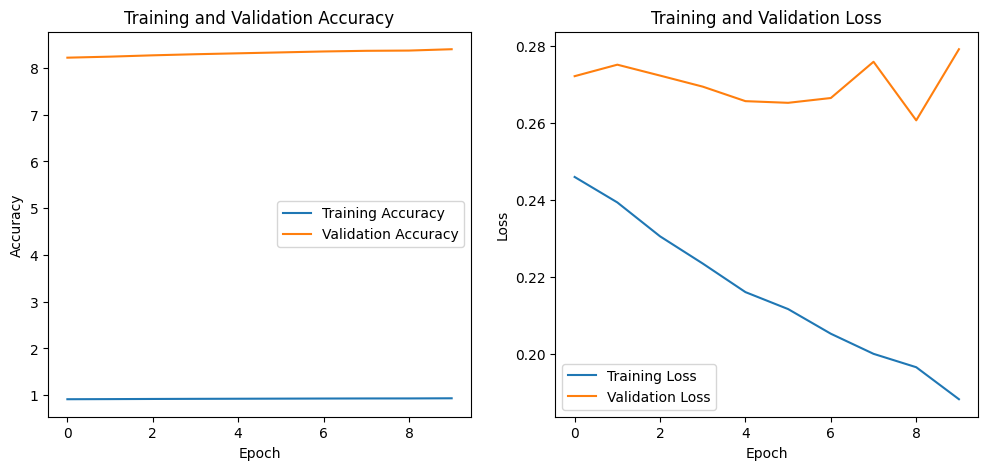

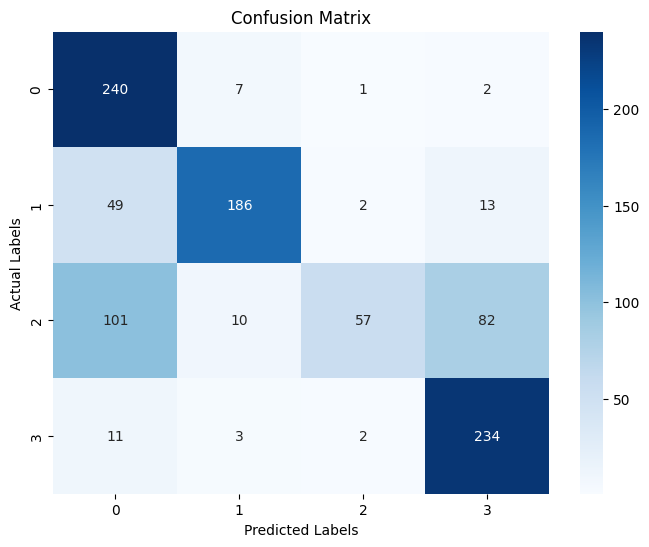

Accuracy: 0.6650
Precision: 0.7819, Recall: 0.7170, F1 Score: 0.6810


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()
model = CNNwDrop()
train_accs, val_accs = [], []
train_losses, val_losses = [], []

best_val_loss = float('inf')
patience = 5
num_epochs = 15
patience_counter = 0


for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct = 0
    total_images = 0

    for images, labels in train_loader:
        labels = labels.squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct / total_images
    train_accs.append(train_accuracy)
    train_losses.append(avg_train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.4f}')

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.squeeze()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_correct / len(val_dataset)
    val_accs.append(val_accuracy)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
        print(f'Validation loss decreased ({best_val_loss:.6f} --> {avg_val_loss:.6f}).Model Saved')
    else:
        patience_counter += 1
        print(f'patience counter: {patience_counter}')
        if patience_counter >= patience:
            print('Early stopping!')
            break

# model.load_state_dict(best_model_state)

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_accs, label='Training Accuracy')
# plt.plot(val_accs, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# plt.show()


# #Confusion Matrix
# model.eval()
# y_true = []
# y_pred = []
# with torch.no_grad():
#     for images, labels in test_loader:
#         labels = labels.squeeze()
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         y_true.extend(labels.cpu().numpy())
#         y_pred.extend(predicted.cpu().numpy())

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.show()

# # Precision, Recall, and F1 Score
# print(f'Accuracy: {accuracy:.4f}')
# precision = precision_score(y_true, y_pred, average='macro')
# recall = recall_score(y_true, y_pred, average='macro')
# f1 = f1_score(y_true, y_pred, average='macro')

# print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


In [ ]:
model.load_state_dict(best_model_state)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


#Confusion Matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.squeeze()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

accuracy = (y_true == y_pred).mean()

# Precision, Recall, and F1 Score
print(f'Accuracy: {accuracy:.4f}')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

In [ ]:
torch.save(model.state_dict(), "/content/model_weights.pkl")

In [ ]:
torch.save(model.state_dict(), "/content/model_weights.h5")

References:
https://github.com/MedMNIST/MedMNIST

Pytorch:
https://pytorch.org/docs/stable/index.html

Matplotlib: https://matplotlib.org/stable/tutorials/index

https://pytorch.org/vision/0.9/transforms.html

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

Some parts of the code like training, evaluation, testing loops are referenced from DL Assignment 0 Part 1 Step 3 Pytorch tutorials.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.